In [1]:
import sys
import numpy as np
from pathlib import Path
from collections import defaultdict

from report_blocks import extract_blocks, BlockInfo


report_path = Path("/home/andre/Documentos/tcc/experiments/reported_blocks_600/")
all_blocks = []

pathlist = Path(report_path).glob('Bikes*.json')
for path in pathlist:
    blocks = extract_blocks(path)
    all_blocks.extend(blocks)


by_lambda = defaultdict(list)
for block in all_blocks:
    by_lambda[block.lf_lambda].append(block)

light_fields = dict()
for lf_lambda, blocks in by_lambda.items():
    lf = dict(
        mse=np.average([b.mse for b in blocks]),
        bpp=np.average([b.bpp for b in blocks]),
        lf_lambda=lf_lambda
    )
    light_fields[lf_lambda] = lf

In [2]:
from bisect import bisect

def estimate_info(lambda_lf):
    lambdas = list(light_fields.keys())
    i = bisect(lambdas, lambda_lf)
    if i == len(lambdas):
        i -= 1
    closest_lambda = lambdas[i]
    lf = light_fields[closest_lambda]
    return lf["bpp"], lf["mse"]

In [131]:
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
from ipywidgets import interact
plt.rcParams['figure.figsize'] = [5, 3]


def bissection(target_rate=0.02, iterations=2):
    lambda_start = 1e3
    lambda_end = 2e4
    data_to_plot = list()

    bpp, mse = estimate_info(lambda_start)
    data_to_plot.append([lambda_start, bpp, mse])
    rate_start = bpp

    if iterations >= 2:
        bpp, mse = estimate_info(lambda_end)
        data_to_plot.append([lambda_end, bpp, mse])
        rate_end = bpp

    for i in range(2, iterations):
        lambda_half = (lambda_start + lambda_end) / 2
        bpp, mse = estimate_info(lambda_half)
        data_to_plot.append([lambda_half, bpp, mse])
        rate_half = bpp

        # Keep the last start-end interval to make the plots easier
        if i < iterations - 1:
            if bpp > target_rate:
                lambda_start = lambda_half
                rate_start = rate_half
            else:
                lambda_end = lambda_half
                rate_end = rate_half

    lambdas = [data[0] for data in data_to_plot]
    bpps = [data[1] for data in data_to_plot]
    mses = [data[2] for data in data_to_plot]
    
    plt.axhline(target_rate, color="black", linestyle="dashed", label="Taxa alvo", zorder=1)
    plt.scatter(lambdas, bpps, color="0.5")
    plt.plot(lambdas, bpps, color="0.8", zorder=0)

    text_params = dict(
        fontsize=12,
        horizontalalignment="center",
        # verticalalignment="top",
        in_layout=True,
        xytext=(10, 7),
        textcoords='offset points',
    )

    if len(lambdas) >= 2:
        plt.annotate(r"$\lambda^{start}$", xy=(lambda_start, rate_start), color="0.3", **text_params)

        plt.annotate(r"$\lambda^{end}$", xy=(lambda_end, rate_end), color="0.3", **text_params)

    if len(lambdas) > 2:
        plt.annotate(r"$\lambda^{half}$", xy=(lambda_half, rate_half), color="crimson", **text_params)

        plt.scatter(lambda_half, rate_half, zorder=1, color="crimson")
    
    plt.legend()
    plt.xlim(-500, 2e4 + 1000)
    plt.ylim(0.008, 0.15)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Bisseção - Iteração {iterations}")
    plt.yscale("log")
    plt.xlabel(r"Multiplicador Lagrangiano ($\lambda$)")
    plt.ylabel("Taxa (bpp)")
    # plt.tight_layout()
    plt.savefig(f"figuras/example_iterations/bissection_iteration_{iterations}.png", dpi=300)
    plt.savefig(f"figuras/example_iterations/bissection_iteration_{iterations}.pdf")
    plt.show()

interact(bissection, target_rate=(0.01, 0.1, 0.01), iterations=(1, 10))


interactive(children=(FloatSlider(value=0.02, description='target_rate', max=0.1, min=0.01, step=0.01), IntSli…

<function __main__.bissection(target_rate=0.02, iterations=2)>

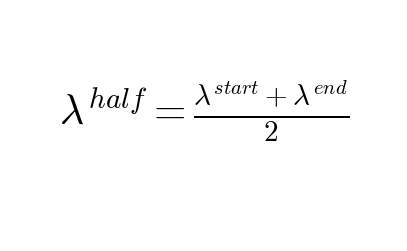

In [122]:
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"


equation = r"$\lambda^{half} = \frac{\lambda^{start} + \lambda^{end}}{2}$"
plt.axis("off")
plt.text(0.5, 0.5, equation, fontsize=30, horizontalalignment="center")
plt.savefig("figuras/equations/bisection.png", transparent=True, dpi=300)
plt.show()


In [132]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from ipywidgets import interact
plt.rcParams['figure.figsize'] = [5, 3]


def hsplit(target_rate=0.02, iterations=2):
    lambda_start = 1e3
    lambda_end = 2e4
    data_to_plot = list()

    bpp, mse = estimate_info(lambda_start)
    data_to_plot.append([lambda_start, bpp, mse])
    rate_start = bpp

    if iterations >= 2:
        bpp, mse = estimate_info(lambda_end)
        data_to_plot.append([lambda_end, bpp, mse])
        rate_end = bpp

    for i in range(2, iterations):
        if rate_start != rate_end:
            b = (np.log(lambda_start) - np.log(lambda_end)) / (np.log(rate_start) - np.log(rate_end))
            a = lambda_start * rate_start ** (-b)
            lambda_half = a * target_rate ** b
        else:
            lambda_half = (lambda_start + lambda_end) / 2

        bpp, mse = estimate_info(lambda_half)
        data_to_plot.append([lambda_half, bpp, mse])
        rate_half = bpp

        if i < iterations - 1:
            if bpp > target_rate:
                lambda_start = lambda_half
                rate_start = rate_half
            else:
                lambda_end = lambda_half
                rate_end = rate_half

    lambdas = [data[0] for data in data_to_plot]
    bpps = [data[1] for data in data_to_plot]
    mses = [data[2] for data in data_to_plot]
    
    plt.axhline(target_rate, color="black", linestyle="dashed", label="Taxa Alvo", zorder=0)
    plt.scatter(lambdas, bpps, color="0.5")
    plt.plot(lambdas, bpps, color="0.9", zorder=0)

    text_params = dict(
        fontsize=12,
        horizontalalignment="center",
        # verticalalignment="top",
        in_layout=True,
        xytext=(10, 7),
        textcoords='offset points',
    )

    if len(lambdas) >= 2:
        plt.annotate(r"$\lambda^{start}$", xy=(lambda_start, rate_start), color="0.3", **text_params)

        plt.annotate(r"$\lambda^{end}$", xy=(lambda_end, rate_end), color="0.3", **text_params)

    if len(lambdas) > 2:
        plt.annotate(r"$\lambda^{half}$", xy=(lambda_half, rate_half), color="crimson", **text_params)

        plt.scatter(lambdas[-1], bpps[-1], color="crimson")

        predicted_bpps = np.linspace(rate_start, rate_end)
        print(rate_start, rate_end)
        predicted_lambdas = a * predicted_bpps ** b
        plt.plot(predicted_lambdas, predicted_bpps, 
                 color="crimson", 
                 linestyle="dotted",
                 label=r"$\alpha * R^{\beta}$",
                 zorder=0,
                )

    plt.legend()
    plt.xlim(-500, 2e4 + 1000)
    plt.ylim(0.008, 0.15)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"H. Split - Codificação {iterations}")
    plt.yscale("log")
    plt.xlabel(r"Multiplicador Lagrangiano ($\lambda$)")
    plt.ylabel("Taxa (bpp)")
    # plt.tight_layout()
    plt.savefig(f"figuras/example_iterations/hsplit_iteration_{iterations}.png", dpi=300)
    plt.savefig(f"figuras/example_iterations/hsplit_iteration_{iterations}.pdf")
    plt.show()

interact(hsplit, target_rate=(0.01, 0.1, 0.01), iterations=(1, 10))

interactive(children=(FloatSlider(value=0.02, description='target_rate', max=0.1, min=0.01, step=0.01), IntSli…

<function __main__.hsplit(target_rate=0.02, iterations=2)>

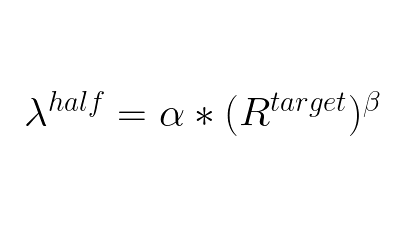

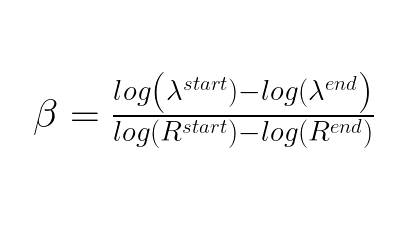

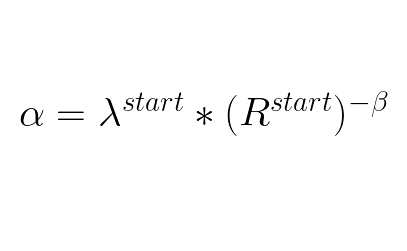

In [126]:
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"


equations = [
    r"$\lambda^{half} = \alpha * (R^{target}) ^ {\beta}$",

    r"$\beta = \frac{log\left(\lambda^{start}) - log(\lambda^{end}\right)}{log(R^{start}) - log(R^{end})}$",

    r"$\alpha = \lambda^{start} * (R^{start}) ^ {-\beta}$",
]

for i, equation in enumerate(equations):
    plt.axis("off")
    plt.text(0.5, 0.5, equation, fontsize=30, horizontalalignment="center", usetex=True)
    plt.savefig(f"figuras/equations/hsplit_{i}.png", transparent=True, dpi=300)
    plt.show()


In [142]:
import matplotlib.pyplot as plt
from ipywidgets import interact
plt.rcParams['figure.figsize'] = [5, 3]


def hslope(target_rate=0.02, iterations=1):
    factor = 1
    last_rate = 0
    data_to_plot = list()

    a = 25
    b = -1.3
    lambda_ = a * (target_rate ** b)

    for i in range(iterations):
        bpp, mse = estimate_info(lambda_)
        data_to_plot.append([lambda_, bpp, mse])

        b = - lambda_ * bpp / mse
        a = mse * bpp ** (-b)
        lambda_estimative = - a * b * target_rate ** (b - 1)

        if np.isclose(lambda_, lambda_estimative):
            break

        if i > 0:
            if bpp < target_rate < last_rate:
                factor *= 0.5
            elif bpp > target_rate > last_rate:
                factor *= 0.5

        lambda_ = lambda_estimative * factor + lambda_ * (1 - factor)
        last_rate = bpp

    print(lambda_)

    lambdas = [data[0] for data in data_to_plot]
    bpps = [data[1] for data in data_to_plot]
    mses = [data[2] for data in data_to_plot]

    text_params = dict(
        fontsize=12,
        horizontalalignment="left",
        # verticalalignment="top",
        in_layout=True,
        xytext=(0, 10),
        textcoords='offset points',
    )

    plt.axhline(target_rate, color="black", linestyle="dashed", label="Taxa Alvo", zorder=0)
    plt.scatter(lambdas, bpps, color="0.5")
    plt.plot(lambdas, bpps, color="0.8", zorder=0)
    plt.scatter(lambdas[-1], bpps[-1], color="crimson")
    plt.annotate(r"$\lambda^{new}$", xy=(lambda_, bpp), color="crimson", **text_params)

    print(a, b)
    if False and len(lambdas) > 1:
        predicted_bpps = np.linspace(min(bpps), max(bpps))
    else:
        predicted_bpps = np.linspace(0.09, 0.01)


    predicted_lambdas = - a * b * predicted_bpps ** (b - 1)
    plt.plot(predicted_lambdas, predicted_bpps, 
                color="crimson",
            linestyle="dotted",
                zorder=0, 
                label=r"$- \alpha * \beta * R^{\beta - 1}$",
            )

    plt.legend()
    plt.xlim(1e2, 4e4)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"H. Slope - Codificação {iterations}")
    plt.yscale("log")
    plt.xlabel(r"Multiplicador Lagrangiano ($\lambda$)")
    plt.ylabel("Taxa (bpp)")
    # plt.tight_layout()
    plt.savefig(f"figuras/example_iterations/hslope_iteration_{iterations}.png", dpi=300)
    plt.savefig(f"figuras/example_iterations/hslope_iteration_{iterations}.pdf")
    plt.show()


interact(hslope, target_rate=(0.01, 0.1, 0.01), iterations=(1, 10))

interactive(children=(FloatSlider(value=0.02, description='target_rate', max=0.1, min=0.01, step=0.01), IntSli…

<function __main__.hslope(target_rate=0.02, iterations=1)>

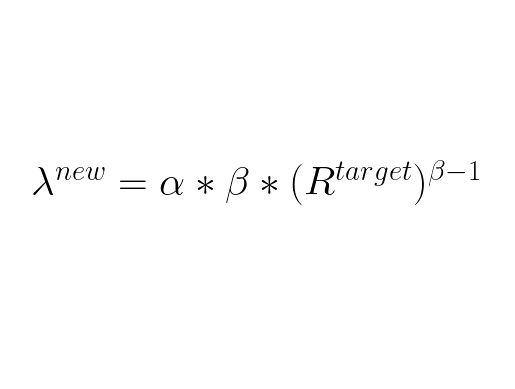

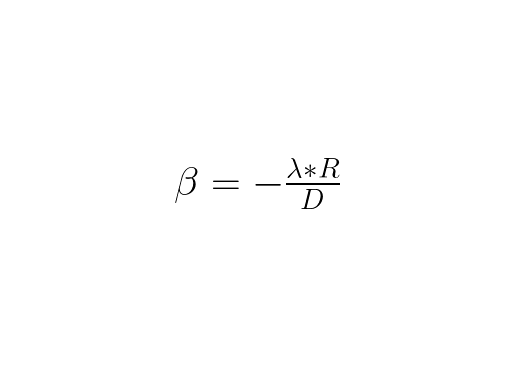

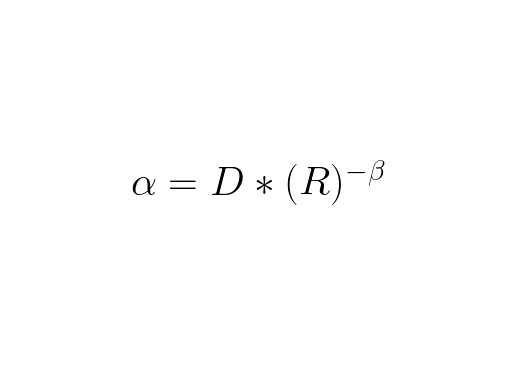

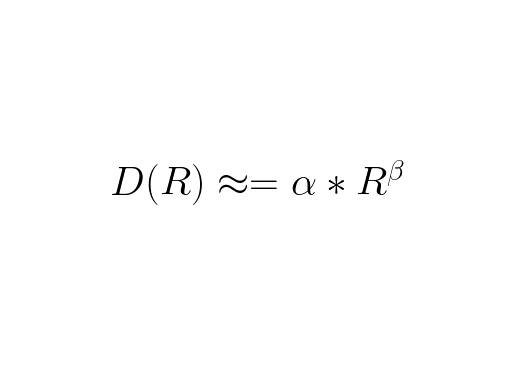

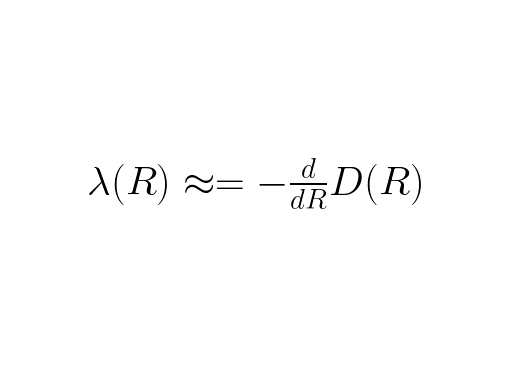

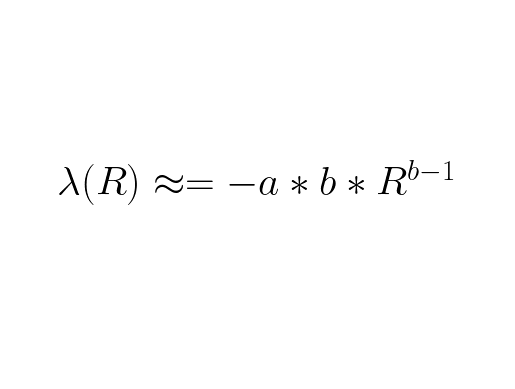

In [49]:
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"


equations = [
    r"$\lambda^{new} = \alpha * \beta * (R^{target}) ^ {\beta - 1}$",

    r"$\beta = - \frac{\lambda * R}{D}$",

    r"$\alpha = D * (R) ^ {-\beta}$",
    
    r"$D(R) \approx= \alpha * R^\beta$",

    r"$\lambda(R) \approx= - \frac{d}{dR} D(R)$",

    r"$\lambda(R) \approx= - a * b * R ^ {b - 1}$",
]

for i, equation in enumerate(equations):
    plt.axis("off")
    plt.text(0.5, 0.5, equation, fontsize=30, horizontalalignment="center", usetex=True)
    plt.savefig(f"figuras/equations/hslope_{i}.png", transparent=True, dpi=300)
    plt.show()
